# Dealias Data from November 10 2018 Using Sounding + Region Based

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyart
import glob
from itertools import groupby
from pathlib import Path


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [71]:
files = sorted(glob.glob('../../data/raw-radar-data/20181110-IOP04/DOW7/radar/cfradial/high/cfrad.20181110_20*el35*'))

In [72]:
radar = pyart.io.read(files[2])

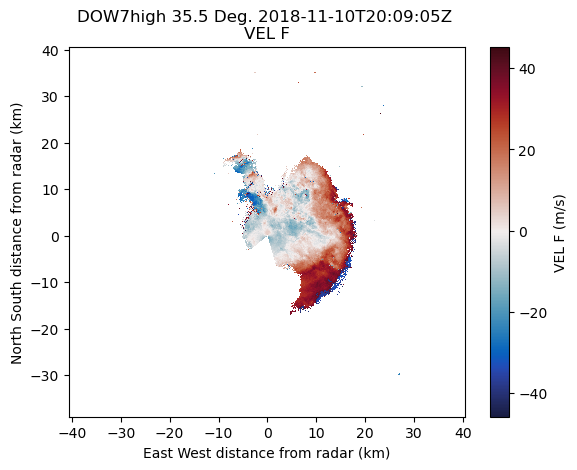

In [103]:
display = pyart.graph.RadarDisplay(radar)
gatefilter=pyart.filters.gatefilter.GateFilter(radar)
gatefilter.exclude_below('SNRHC', 4)
display.plot_ppi('VEL_F',
                 gatefilter=gatefilter,
                 cmap='pyart_balance')

/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/graph/radardisplay.py:99: UserWarning: RadarDisplay does not correct for moving platforms
  warnings.warn("RadarDisplay does not correct for moving platforms")


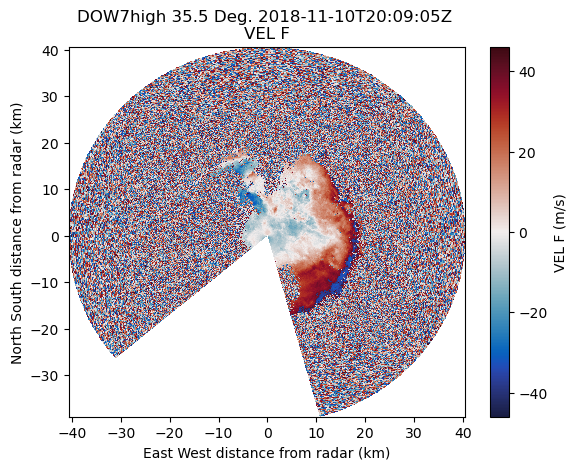

In [85]:
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('VEL_F', cmap='pyart_balance')

In [76]:
nyq = np.array(radar.get_nyquist_vel(0))

vel_texture = pyart.retrieve.calculate_velocity_texture(
    radar, vel_field="VEL_F", wind_size=3, nyq=nyq,
)
radar.add_field("velocity_texture", vel_texture, replace_existing=True)

Text(0, 0.5, 'Count')

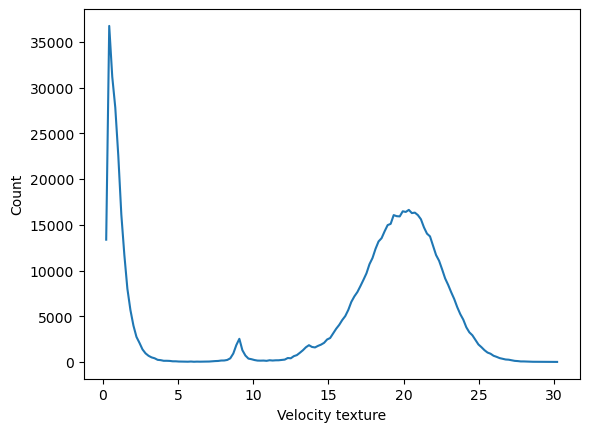

In [77]:
hist, bins = np.histogram(radar.fields["velocity_texture"]["data"], bins=150)
bins = (bins[1:] + bins[:-1]) / 2.0
plt.plot(bins, hist)
plt.xlabel("Velocity texture")
plt.ylabel("Count")

In [126]:
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_above("velocity_texture", 12)

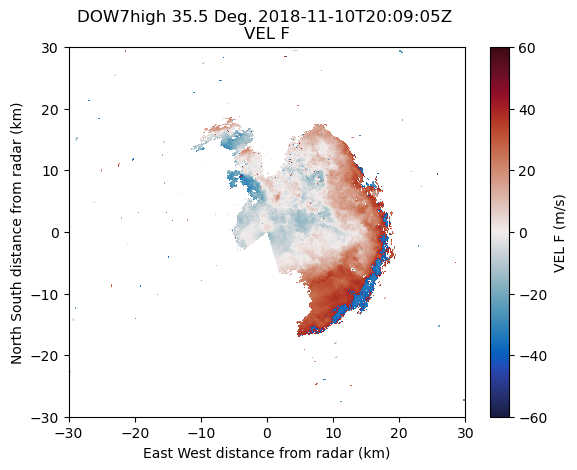

In [127]:
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('VEL_F',
                 cmap='pyart_balance',
                 sweep=0,
                 vmin=-60,
                 gatefilter=gatefilter,
                 vmax=60)
plt.xlim(-30, 30)
plt.ylim(-30, 30);

In [128]:
df = pd.read_table('../../data/soundings/uiuc1-nov-10.txt', skiprows=[1, 2], delim_whitespace=True)

In [129]:
df_qc = df.loc[df.Qu == 1]

In [130]:
height = df_qc.Alt.values
speed = df_qc.spd.values
direction = df_qc.dir.values
lat = df_qc.Lat.values
lon = df_qc.Lon.values

In [131]:
profile = pyart.core.HorizontalWindProfile(height,
                                 speed,
                                 direction,
                                 latitude=lat,
                                 longitude=lon)

In [132]:
profile_radar_field = pyart.util.simulated_vel_from_profile(radar, profile)

In [133]:
radar.add_field('profile_simulated_velocity',
                profile_radar_field,
                replace_existing=True)

/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/graph/radardisplay.py:99: UserWarning: RadarDisplay does not correct for moving platforms
  warnings.warn("RadarDisplay does not correct for moving platforms")


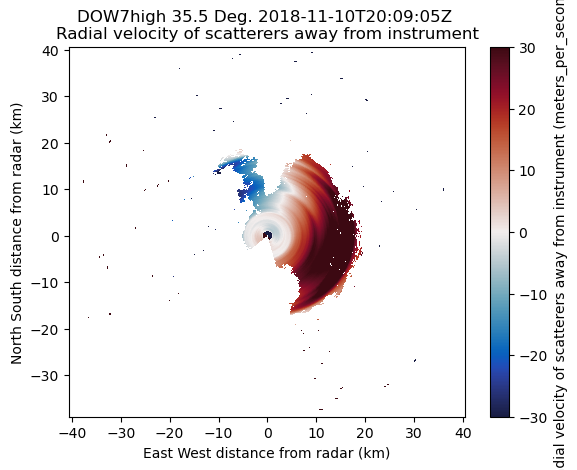

In [134]:
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('profile_simulated_velocity',
                 cmap='pyart_balance',
                 sweep=0,
                 vmin=-30,
                 gatefilter=gatefilter,
                 vmax=30)

In [135]:
corrected_velocity = pyart.correct.dealias_region_based(radar,
                                   gatefilter=gatefilter,
                                   vel_field='VEL_F',
                                   ref_vel_field='profile_simulated_velocity')

/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3753     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.15738D+10    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3753      0      1      0     0     0   6.000D+00   2.157D+10
  F =   21573843113.013634     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [136]:
radar.add_field("corrected_velocity", corrected_velocity, replace_existing=True)

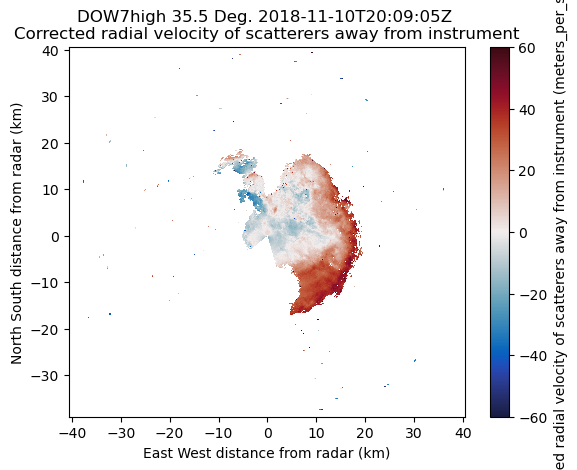

In [137]:
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('corrected_velocity',
                 cmap='pyart_balance',
                 sweep=0,
                 vmin=-60,
                 gatefilter=gatefilter,
                 vmax=60)